In [4]:
import numpy as np
print("NumPy version:", np.__version__)

import skimage
print("skimage version:", skimage.__version__)

import sklearn
print("sklearn version:", sklearn.__version__)

import matplotlib
print("matplotlib version:", matplotlib.__version__)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)

import sys
print("Python version:", sys.version)


NumPy version: 1.17.3
skimage version: 0.15.0
sklearn version: 0.24.2
matplotlib version: 3.2.1
TensorFlow version: 1.15.0
Keras version: 2.2.4
Python version: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]


Using TensorFlow backend.


In [5]:
import os
import json
import numpy as np
import skimage.io
import skimage.draw
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import log

ROOT_DIR = "C:\\Users\\Hon\\Documents\\skipsi\\ehon\\Skripsi-Hon"
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Konfigurasi Model
class CustomConfig(Config):
    NAME = "object"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3
    STEPS_PER_EPOCH = 70
    DETECTION_MIN_CONFIDENCE = 0.5
    VALIDATION_STEPS = 33
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    LEARNING_RATE = 0.001

# Dataset Custom
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        self.add_class("object", 1, "sawah")
        self.add_class("object", 2, "bangunan")
        self.add_class("object", 3, "landasan")

        assert subset in ["tes"]
        dataset_dir = os.path.join(dataset_dir, subset)

#         annotations1 = json.load(open(os.path.join(dataset_dir, f'{subset}.json')))
        annotations1 = json.load(open('C:\\Users\\Hon\\Documents\\skipsi\\ehon\\Skripsi-Hon\\Dataset\\tes\\tes.json'))
        annotations = list(annotations1.values())
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            name_dict = {"sawah": 1, "bangunan": 2, "landasan": 3}
            num_ids = [name_dict[a] for a in objects]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
            )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            rr[rr >= mask.shape[0]] = mask.shape[0] - 1  # Handle out-of-bounds indices
            cc[cc >= mask.shape[1]] = mask.shape[1] - 1  # Handle out-of-bounds indices
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            return super(self.__class__, self).image_reference(image_id)

# Lokasi model dan dataset
model_path = "C:\\Users\\Hon\\Documents\\skipsi\\ehon\\Skripsi-Hon\\logs\\object20240703T0035\\mask_rcnn_object_0040.h5"
dataset_dir = "C:\\Users\\Hon\\Documents\\skipsi\\ehon\\Skripsi-Hon\\Dataset"

# Load Model Config
config = CustomConfig()
config.display()

# Load Model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=os.path.dirname(model_path))
model.load_weights(model_path, by_name=True)

# Load Dataset
dataset = CustomDataset()
dataset.load_custom(dataset_dir, "tes")
dataset.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
class_names = ['BG', 'sawah', 'bangunan', 'landasan']

In [7]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (815, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


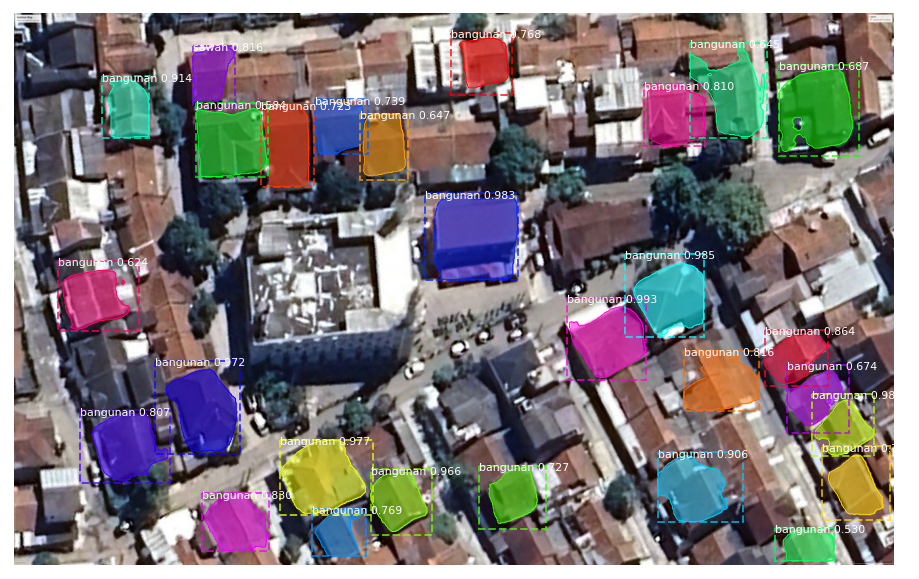

In [13]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

results = model.detect([image], verbose=1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (815, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


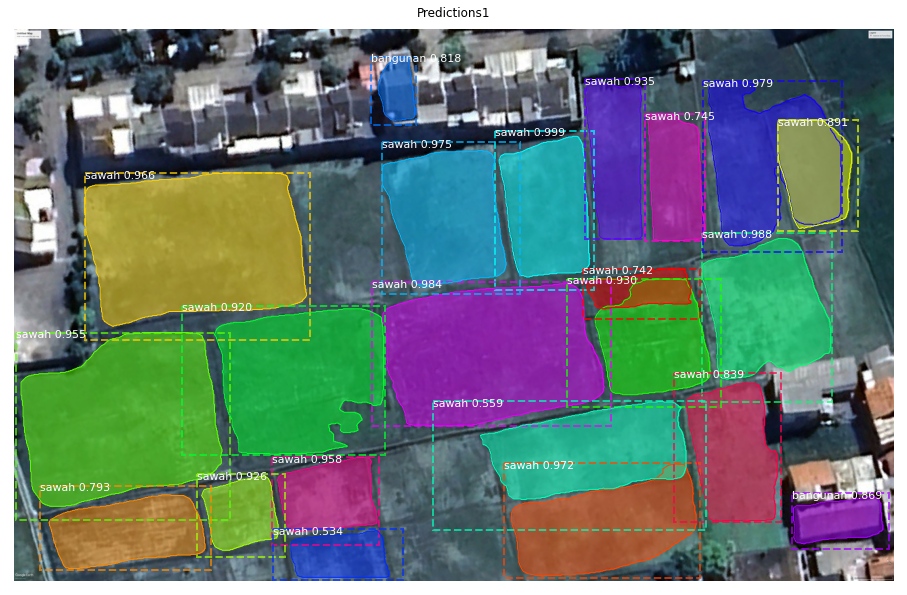

In [8]:
path_to_new_image = 'C:\\Users\\Hon\\Documents\\skipsi\\ehon\\Skripsi-Hon\\images\\31.jpg'
image1 = mpimg.imread(path_to_new_image)

results1 = model.detect([image1], verbose=1)

ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset.class_names, r1['scores'], ax=ax, title="Predictions1")